In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import math

import datetime
import pandas as pd
import seaborn as sns
import tensorflow as tf

from opt_weights import *
from model_inputs import *
from model import *

notes:
- autoencode - regularize
- model only has holes when Xs is missing data -build_Xs_from_returns(ret, 10) leads to big holes
- add function to combine different signals (momentum, value, prev returns) 
  - shold allow for returning 2d or 1d
- add convolution layer to build common up/dn forecast
- figure out how to keep n225 from always being only selected ticker

In [2]:
# import pandas.io.data as web
# start_date = datetime.date(2005,1,1)
# end_date = datetime.date(2012,5,1)
# px = web.DataReader(["^GSPC", "^DJI", "^IXIC", "^FCHI", "^FTSE", "^N225"] , 'yahoo', start_date, end_date).Close
# ret = px.div(px.shift()).dropna()
ret = pd.read_csv('tests/test_data/returns.csv', parse_dates=['Date'], index_col=0)

In [3]:
risk = .2
scaler = risk / (ret.std() * math.sqrt(250.))
ret = ((ret - 1.) * scaler).applymap(lambda x: x + 1.)

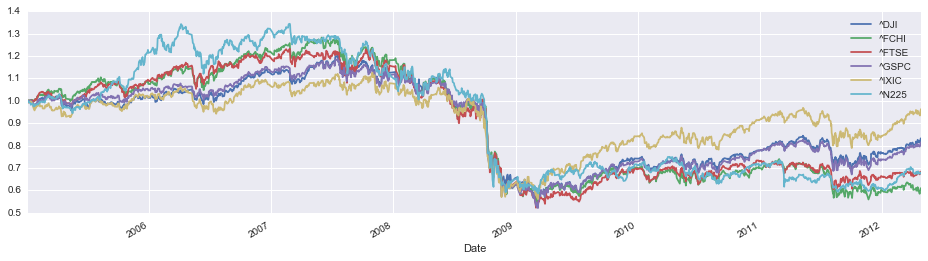

In [4]:
ret.cumprod().plot(figsize=[16,4])

find optimal target regression parameters

In [5]:
#grid = cum_prod_grid(ret, np.exp(np.linspace(-20, 1, 5)), look_ahead_pers=xrange(1,32,10))
#grid[grid.norm_type==2].pivot(index='alpha', columns='look_ahead_per', values='cum_ret')

prep model inputs

In [6]:
opt_weights_func = lambda x: calc_opt_weights(x, alpha=0.000653, norm_type=2)
opt_weights = rolling_fit_opt_weights(ret, opt_weights_func, 20)
ys = pd.DataFrame(opt_weights.values, index=opt_weights.index, columns=opt_weights.columns)

In [7]:
#Xs = build_Xs_from_returns(ret, 10)

In [8]:
def get_peak_ahead_returns(returns, per):
    """returns demeaned peaked ahead returns"""
    cum_rets = returns.cumprod()
    fwd_rets = cum_rets.shift(-per).div(cum_rets)
    fwd_rets = fwd_rets.dropna(how='all')
    return fwd_rets.sub(fwd_rets.mean(axis=1), axis=0)

Xs = get_peak_ahead_returns(ret, 20)

In [19]:
print ret.index
print Xs.index

DatetimeIndex(['2005-01-05', '2005-01-06', '2005-01-07', '2005-01-12',
               '2005-01-13', '2005-01-14', '2005-01-19', '2005-01-20',
               '2005-01-21', '2005-01-24',
               ...
               '2012-04-16', '2012-04-17', '2012-04-18', '2012-04-19',
               '2012-04-20', '2012-04-23', '2012-04-24', '2012-04-25',
               '2012-04-26', '2012-04-27'],
              dtype='datetime64[ns]', name=u'Date', length=1584, freq=None)
DatetimeIndex(['2005-01-05', '2005-01-06', '2005-01-07', '2005-01-12',
               '2005-01-13', '2005-01-14', '2005-01-19', '2005-01-20',
               '2005-01-21', '2005-01-24',
               ...
               '2012-03-12', '2012-03-13', '2012-03-14', '2012-03-15',
               '2012-03-16', '2012-03-19', '2012-03-22', '2012-03-23',
               '2012-03-26', '2012-03-27'],
              dtype='datetime64[ns]', length=1564, freq=None)


In [9]:
# length = 1000
# dti = pd.DatetimeIndex(start='2000-1-1', freq='B', periods=length)
# #Xs = gen_random_normal(dti, 20)
# ys = gen_random_probs(dti, 10)
# #ys = gen_random_onehot(dti, 10)
# Xs = ys.copy(deep=True)

In [10]:
Xs.equals(ys)

False

In [11]:
print Xs.shape
print ys.shape
Xs, ys = validate_and_format_Xs_ys(Xs, ys)
print Xs.shape
print ys.shape
train, test = split_inputs_by_date(Xs, ys, datetime.date(2200,1,1), buffer_days=1)
Xs_train, ys_train = train[0].values, train[1].values 

(1564, 6)
(1564, 6)
(1564, 6)
(1564, 6)


In [12]:
# from tensorflow.examples.tutorials.mnist import input_data
# mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
#Xs, ys = mnist.train.next_batch(1500)

n hidden layers with softmax

In [26]:
from model import *
probs, labels, stats = train_nn_softmax(Xs_train, ys_train, [10], 2000, 1000, .4)

step     0:	loss: 1.84	(0.06 sec)
step   100:	loss: 1.70	(0.41 sec)
step   200:	loss: 1.70	(0.77 sec)
step   300:	loss: 1.70	(1.15 sec)
step   400:	loss: 1.71	(1.49 sec)
step   500:	loss: 1.69	(1.84 sec)
step   600:	loss: 1.70	(2.19 sec)
step   700:	loss: 1.70	(2.51 sec)
step   800:	loss: 1.70	(2.83 sec)
step   900:	loss: 1.70	(3.18 sec)
step  1000:	loss: 1.70	(3.48 sec)
step  1100:	loss: 1.70	(3.89 sec)
step  1200:	loss: 1.70	(4.25 sec)
step  1300:	loss: 1.70	(4.57 sec)
step  1400:	loss: 1.70	(4.93 sec)
step  1500:	loss: 1.70	(5.28 sec)
step  1600:	loss: 1.70	(5.63 sec)
step  1700:	loss: 1.71	(5.99 sec)
step  1800:	loss: 1.70	(6.32 sec)
step  1900:	loss: 1.69	(6.67 sec)
accuracy:	0.647698223591
cross entropy:	1.69885361195


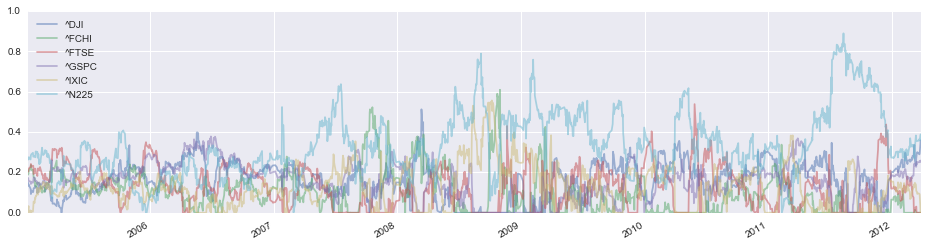

In [27]:
ys.plot(figsize=[16,4], ylim=[0,1], alpha=.5)

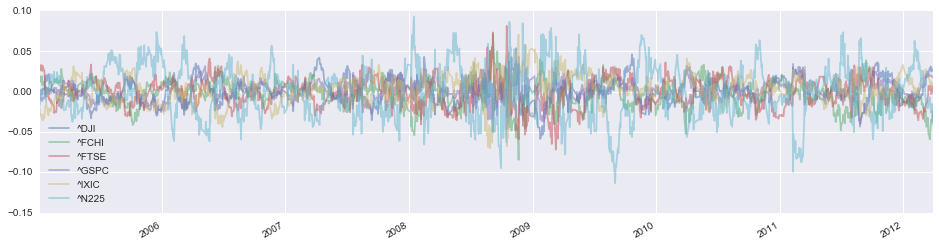

In [28]:
Xs.plot(alpha=.5, figsize=[16,4])

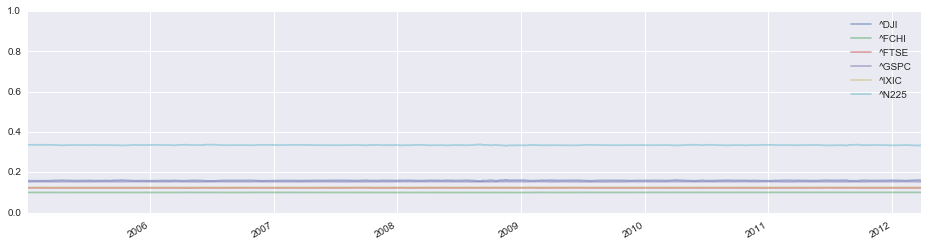

In [29]:
probs = pd.DataFrame(probs, columns=ys.columns, index=ys.index)
probs.plot(figsize=[16,4], ylim=[0,1], alpha=.5)

In [24]:
cols = list(ys.columns)
cols = dict(map(lambda x: (cols.index(x), x), cols))
labels = pd.Series(labels).map(lambda x: cols[x])
print('predicted max columns:')
print labels.value_counts()
print
print('actual max columns:')
print ys.apply(lambda x: list(x).index(max(x)), axis=1).map(lambda x: cols[x]).value_counts()

predicted max columns:
^N225    1564
dtype: int64

actual max columns:
^N225    1013
^GSPC     165
^DJI      147
^FTSE     108
^FCHI      72
^IXIC      59
dtype: int64


analytics

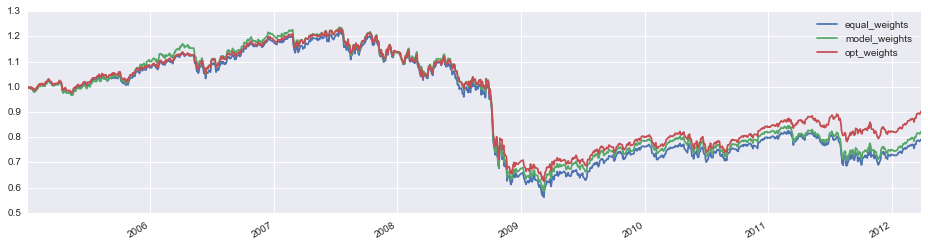

In [25]:
equal_weights = pd.Series({k: 1./ret.shape[1] for k in ret.columns})
perf = pd.DataFrame({'equal_weights': ret.mul(equal_weights).sum(axis=1),
                     'opt_weights': ret.mul(opt_weights).sum(axis=1),
                     'model_weights': ret.mul(probs).sum(axis=1)
                    })
perf.ix[Xs.index].cumprod().plot(figsize=[16,4])